In [6]:
%run -i harm_script.py

In [7]:
rg("gdump")

In [8]:
rd("dump000")

In [ ]:
print(t)

In [ ]:
plt.loglog(r[:,ny//2,0], rho[:,ny//2,0])
plt.xlabel("r")
plt.ylabel("rho")

In [ ]:
plco(np.log10(rho),xy=1,xmax=100,ymax=50,cb=True, isfilled=1, nc=100)
# phi goes into the plane of the image

In [ ]:
!ls dumps

In [ ]:
import numpy as np
for i in np.arange(2):
    print(i)
    rd("dump%03d" % i)
    plco(np.log10(rho),xy=1,xmax=100,ymax=50,cb=True,isfilled=1,nc=100)
    plt.savefig("films/frame%03d.png" % i, dpi=300)

# for i in np.arange():
#     rd(f"dump00{i}")
#     plco(np.log10(rho),xy=1,xmax=100,ymax=50,cb=True, isfilled=1, nc=100)
#     plt.savefig(f"frame i")

In [ ]:
!ls *.png

In [ ]:
!ffmpeg -fflags +genpts -r 10 -pattern_type glob -i "frame*.png" -vcodec mpeg4 -qmax 5 movie.mp4

In [20]:
# gcov: 
# rhor: event horizon radius
# phi, theta, 
# B is magnetic fields

# internal coordinates??? theta on y, log r on x
# plco(np.log10(rho),xy=0,cb=True,isfilled=1,nc=100)

# rho, ug, uu[1:4], B[1:4]
# rd means read dump

globals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', '__file__', 'matplotlib', 'plt', 'mpl', 'sys', 'rc', 'Ellipse', 'interp1d', 'GridSpec', 'cm', 'ticker', 'sin', 'cos', 'tan', 'pi', 'axes', 'fix_cross_in_labels', 'pdb', 'np', 'glob', 'os', 'griddata', 'ma', 'colors', 'mathify_axes_ticks', 'convert_to_single_file', 'ellk', 'ek', 'lk', 'Risco', 'Ebind', 'etaNT', 'Ebindisco', 'mkmov_simple', 'convert_wrapper', 'mkmov_wrapper', 'mkmov', 'mkfrmsimple', 'mkvertcolorbar', 'Qmri', 'goodlabs', 'iofr', 'rd', 'rg', 'rg2', 'read_file', 'read_header', 'read_body', 'data_assign', 'gdump_assign', 'gdump2_assign', 'dump_assign', 'rdump_assign', 'fdump_assign', 'mdot', 'psicalc', 'myfloat', 'get_fracphi', 'plco', 'plc', 'faraday', 'Tcalcud', 'aux', 'bhole', 'testfail', 'get_sorted_file_list', 'fFdd', 'delta', 

In [ ]:
# TODO we need a function that loops over all dumps in the file system
import os
import re
dumps = []
for filename in os.listdir('dumps'):
    if re.match(r'^dump\d+$', filename):
        dumps.append(filename)
dumps.sort()
num_dumps = len(dumps)
print(f'Number of Dumps: {num_dumps}')


['dump141', 'dump179', 'dump146', 'dump170', 'dump148', 'dump177', 'dump123', 'dump124', 'dump112', 'dump115', 'dump149', 'dump176', 'dump171', 'dump178', 'dump147', 'dump140', 'dump114', 'dump113', 'dump125', 'dump122', 'dump050', 'dump068', 'dump057', 'dump061', 'dump095', 'dump059', 'dump092', 'dump066', 'dump032', 'dump035', 'dump003', 'dump004', 'dump058', 'dump067', 'dump093', 'dump094', 'dump060', 'dump069', 'dump056', 'dump051', 'dump005', 'dump002', 'dump034', 'dump033', 'dump011', 'dump029', 'dump016', 'dump020', 'dump018', 'dump027', 'dump073', 'dump087', 'dump080', 'dump074', 'dump042', 'dump089', 'dump045', 'dump019', 'dump026', 'dump021', 'dump028', 'dump017', 'dump010', 'dump044', 'dump043', 'dump088', 'dump075', 'dump081', 'dump086', 'dump072', 'dump100', 'dump138', 'dump107', 'dump131', 'dump109', 'dump136', 'dump162', 'dump165', 'dump153', 'dump154', 'dump108', 'dump137', 'dump130', 'dump139', 'dump106', 'dump101', 'dump155', 'dump152', 'dump164', 'dump163', 'dump127'

In [ ]:
# TODO we need a function to translate a dump and the variables it reads into NN friendly tensors
import torch

# TODO make dataset
data = []
for dump in dumps:
    rd(dump)

    rho_tensor = torch.tensor(rho).squeeze(2).unsqueeze(0)
    ug_tensor = torch.tensor(ug).squeeze(2).unsqueeze(0)
    uu_tensor = torch.tensor(uu[1:4]).squeeze(3)
    B_tensor = torch.tensor(B[1:4]).squeeze(3)
    
    data_tensor = torch.cat((rho_tensor, ug_tensor, uu_tensor, B_tensor), dim=0)
    data.append(data_tensor.unsqueeze(0))

data = torch.cat(data, dim=0)
print(f'Shape of the dataset: {data.shape}')

Shape of the dataset: torch.Size([181, 8, 128, 128])


In [38]:
from torch.utils.data import Dataset, DataLoader, random_split
BATCH_SIZE = 8

class BHDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)-1

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.dataset[idx+1]
        return data, label

loaded_data = BHDataset(data)
train_size = int(0.7 * len(loaded_data))
val_size = int(0.15 * len(loaded_data))
test_size = len(loaded_data) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(loaded_data, [train_size, val_size, test_size])

# TODO make dataloaders
# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [43]:
import torch.nn as nn
# TODO write the NN
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        return x

In [47]:
# TODO initialize net, loss, optim
net = FFNN(input_dim = 8*128*128)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(params=net.parameters())

# TODO training script
losses = []
epochs = 2
for epoch in range(epochs):
    for batch_num, (batch, label) in enumerate(train_loader):
        # zero gradients
        optim.zero_grad()
        batch_len = len(batch)

        # 
        batch_reshaped = torch.reshape(batch, (batch_len,8*128*128))

        # make prediction
        pred = net.forward(batch_reshaped)
        pred_reshaped = torch.reshape(pred, (batch_len,8,128,128))

        # compute loss
        loss_value = loss_fn(pred_reshaped, label)
        losses.append(loss_value)

        loss_value.backward()

        optim.step()

        print(f"Loss value: {loss_value}")


Loss value: 0.27148398756980896
Loss value: 0.029041476547718048
Loss value: 1.4512519836425781
Loss value: 0.08424919843673706
Loss value: 0.41669967770576477
Loss value: 0.13125692307949066
Loss value: 0.6574243903160095
Loss value: 0.40136271715164185
Loss value: 0.3904631733894348
Loss value: 0.007838951423764229
Loss value: 0.3450261950492859
Loss value: 0.09562171995639801
Loss value: 0.638245165348053
Loss value: 0.4129607081413269
Loss value: 0.0077140009962022305
Loss value: 0.03824084997177124
Loss value: 0.0934142917394638
Loss value: 0.08769495040178299
Loss value: 0.3580416738986969
Loss value: 0.165430948138237
Loss value: 0.06786205619573593
Loss value: 0.36764711141586304
Loss value: 0.6100798845291138
Loss value: 0.15984763205051422
Loss value: 0.3637657165527344
Loss value: 0.041916653513908386
Loss value: 0.006337180733680725
Loss value: 0.3799276053905487
Loss value: 0.13570870459079742
Loss value: 0.38579508662223816
Loss value: 0.17995548248291016
Loss value: 0.69

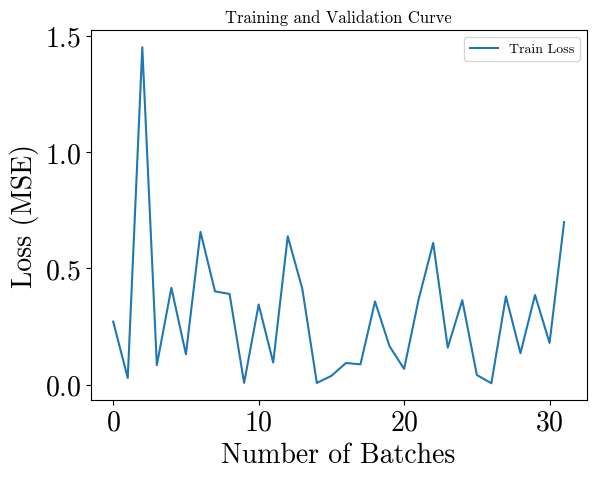

In [ ]:
plt.plot([i for i in range(len(losses))], [loss.item() for loss in losses], label='Train Loss')
plt.title(f'Training and Validation Curve')
plt.xlabel(f'Number of Batches')
plt.ylabel(f'Loss (MSE)')
plt.legend()
plt.show()

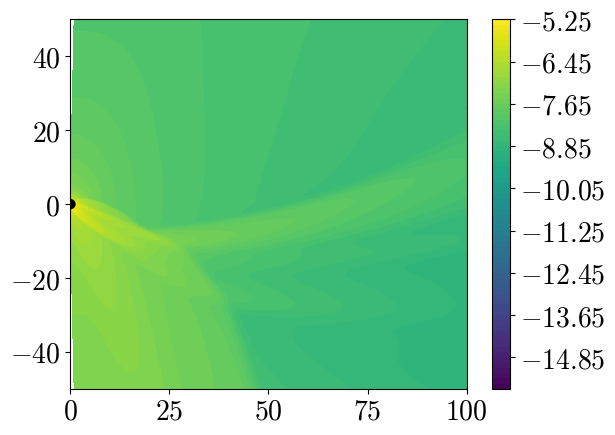

In [ ]:
import matplotlib.pyplot as plt

# TODO create side by side movie for prediction
#   TODO figure out how plotting stuff works 
#   TODO make function that does all this shit in memory instead of individual pdf frames
#   TODO make a final movie making function

for dump in dumps:
    rd(dump)
    plco(np.log10(rho), xy=1, xmax=100, ymax=50, cb=True, isfilled=1, nc=100)
    plt.savefig(f"films/film1/{dump}.png", dpi=300)

